<a href="https://colab.research.google.com/github/mldessu/projetsimu/blob/main/Chaleur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 1. Équation considérée

Nous partons de l’équation de diffusion thermique :

$$
C_v\,\rho \,\frac{\partial T(x,t)}{\partial t}
\;=\;
k\,\frac{\partial^2 T(x,t)}{\partial x^2}
\;+\;
S(x),
$$

où :

- $T(x,t)$ est la température dans le mur,  
- $C_v$ est la capacité thermique massique,  
- $\rho$ la masse volumique,  
- $k$ la conductivité thermique,  
- $S(x)$ un terme source (ex. chauffage volumique interne).



## 2. Conditions aux limites en forme générale

### 2.1. Condition de Robin (convection) à \(x=0\)

La forme **générale** est :

$$
c_1\,\frac{\partial T}{\partial x}\Big|_{x=0}
\;+\;
c_2\,T(0,t)
\;+\;
c_3
\;=\;
0.
$$

Ici, nous avons :
$$
-\,k\,\frac{\partial T}{\partial x}(0,t)
\;=\;
h\,\bigl(T_a - T(0,t)\bigr)
$$
ce qui se réécrit :
$$
\underbrace{(-k)}_{c_1} \,\frac{\partial T}{\partial x}(0,t)
\;+\;
\underbrace{(h)}_{c_2}\,T(0,t)
\;+\;
\underbrace{(-h\,T_a)}_{c_3}
\;=\;
0.
$$

### 2.2. Condition de Dirichlet (température imposée) à \(x=L\)

Pour imposer \(T(L,t) = T_i\), la forme générale serait :

$$
d_1\,\frac{\partial T}{\partial x}\Big|_{x=L}
\;+\;
d_2\,T(L,t)
\;+\;
d_3
\;=\;
0,
$$


Les **conditions aux limites** sont :

- **À \( x=0 \) (face externe)** :  
$$
-k\,\frac{\partial T(0,t)}{\partial x} = h\,\bigl(T_a-T(0,t)\bigr),\quad \text{avec } h = 1\,\mathrm{W/(m^2\,K)}.
$$

- **À \( x=L \) (face interne)** :  
  $$
  T(L,t) = T_i = 20^\circ\text{C}.
  $$

La **condition initiale** est donnée par :

$$
T(x,0) = T_w + \bigl(T_i - T_w\bigr)\frac{x}{L},
$$

avec

$$
T_w = \frac{T_i\,\frac{k}{L} + T_a\,h}{\frac{k}{L} + h}.
$$

## 3. Source de Chaleur

Nous considérons une source de chaleur ayant un profil  comme definis dans l'énoncé. 

$$
S(x) = \frac{q}{1 + \left(\frac{x-L}{dL}\right)^2},
$$


## 4. Méthode implicite 

Pour simuler l’évolution temporelle vers l’état stationnaire, nous utilisons un schéma implicite. Le domaine spatial \([0,L]\) est discrétisé uniformément avec un pas

$$
dx = 0.003\,\text{m},
$$

et le temps est discrétisé en pas \( dt \) on a, dt = $\frac{\rho\,C\,dx^2}{2k}$  de sorte à garantir la stabilité numérique.

Pour discrétiser l'évolution temporelle, nous utilisons un schéma implicite basé sur la formulation générale :

$$
\frac{C_v\,\rho}{k}\,\frac{T^{p+1} - T^p}{dt} = \xi\,\frac{\partial^2 T^{p+1}}{\partial x^2} + (1-\xi)\,\frac{\partial^2 T^p}{\partial x^2} + \frac{S(x)}{k}.
$$

- Ici, nous choisissons $\xi = 1$ c'est-à-dire $\epsilon = 1$, ce qui correspond au schéma d'Euler implicite  où toute la contribution de la diffusion est évaluée au temps $t_{p+1}$.

La discrétisation de l’opérateur de diffusion par différences finies conduit à la formulation matricielle :

$$
A\,T^{p+1} = b,
$$

où la matrice \( A \) intègre la discrétisation en différences centrées de la dérivée seconde ainsi que les conditions aux limites (Robin en  x=0) et Dirichlet en \( x=L \)), et le vecteur \( b \) intègre la contribution de la solution précédente et du terme source.

À chaque pas de temps, nous résolvons ce système linéaire pour obtenir $T^{p+1}$ et nous continuons la simulation jusqu’à ce que la différence entre deux itérations successives soit inférieure à une tolérance fixée, indiquant que l'état stationnaire est atteint.



Le code Python correspondant, qui met en œuvre cette méthode est présenté dans la cellule suivante.

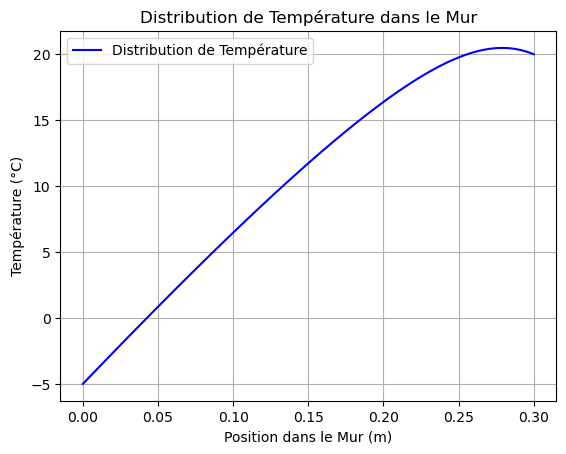

Temps d'équilibre atteint : 9127.05882352941 secondes
Température maximale à l'équilibre : 20.477475624966885 °C


In [7]:
import numpy as np
import matplotlib.pyplot as plt

#######################################################
# Paramètres du problème
#######################################################
epaisseur_mur = 0.3                # Épaisseur du mur (m)
temperature_interieure = 20        # Température imposée à l'intérieur (°C)
temperature_exterieure = -10       # Température ambiante extérieure (°C)
puissance_volumique = 2000         # Puissance volumique (W/m³)
conductivite_thermique = 0.85      # Conductivité thermique (W/(m*K))
coef_convection = 20               # Coefficient de convection (W/(m²*K))
capacite_thermique = 1000          # Capacité thermique spécifique (J/(kg*K))
masse_volumique = 2000             # Masse volumique du matériau (kg/m³)
param_distribution = 0.05          # Paramètre pour la distribution spatiale de la source

#######################################################
# Discrétisation spatiale et temporelle
#######################################################
pas_espace = 0.003                                   # Pas spatial (m)
nb_intervalles = int(epaisseur_mur / pas_espace)       # Nombre d'intervalles dans le mur
positions = np.linspace(0, epaisseur_mur, nb_intervalles + 1)  # Coordonnées spatiales

# Calcul du pas de temps en respectant la condition de stabilité 
pas_temps = (masse_volumique * capacite_thermique * pas_espace**2) / (2 * conductivite_thermique)
temps_total = 1e6                                    # Durée totale de la simulation (s)
nb_pas_temps = int(temps_total / pas_temps)          # Nombre total de pas de temps

#######################################################
# Conditions initiales et terme source
#######################################################
# Initialisation de la température : on part de la température extérieure sur tout le mur,
# sauf à la face intérieure où la température est imposée.
temperature = np.full(nb_intervalles + 1, temperature_exterieure)
temperature[-1] = temperature_interieure

# Terme source tel que spécifié dans l'énoncé
source_chaleur = puissance_volumique / (1 + ((positions - epaisseur_mur) / param_distribution) ** 2)

#######################################################
# Construction de la matrice pour le schéma implicite
#######################################################
# Discrétisation implicite de l'équation de la chaleur
coefficient = conductivite_thermique * pas_temps / (masse_volumique * capacite_thermique * pas_espace**2)
matrice_systeme = np.diag((1 + 2 * coefficient) * np.ones(nb_intervalles + 1))
matrice_systeme += np.diag(-coefficient * np.ones(nb_intervalles), k=-1)
matrice_systeme += np.diag(-coefficient * np.ones(nb_intervalles), k=1)

# Conditions aux limites :
# Bord extérieur (x = 0) : condition de convection avec l'air extérieur
matrice_systeme[0, 0] = 2 * coef_convection * pas_espace + 3 * conductivite_thermique
matrice_systeme[0, 1] = -4 * conductivite_thermique
matrice_systeme[0, 2] = conductivite_thermique

# Bord intérieur (x = epaisseur_mur) : température imposée (condition de Dirichlet)
matrice_systeme[-1, :] = 0
matrice_systeme[-1, -1] = 1

#######################################################
# Simulation temporelle
#######################################################
temps_equilibre = None            # Stockera le temps d'atteinte de l'équilibre
instants_simulation = []          # Stocke les instants de temps (pour suivi éventuel)
valeurs_temp_max = []             # Stocke la température maximale à chaque pas

tolerance = 0.01  # Tolérance pour déterminer que la solution a convergé

for indice in range(nb_pas_temps):
    temps_courant = indice * pas_temps

    # Construction du second membre du système avec la contribution de la source
    second_membre = temperature + pas_temps * source_chaleur / (masse_volumique * capacite_thermique)
    second_membre[0] = -2 * (-coef_convection * temperature_exterieure) * pas_espace  # Condition de convection au bord extérieur
    second_membre[-1] = temperature_interieure  # Condition de Dirichlet au bord intérieur

    # Résolution du système linéaire pour obtenir la température à l'instant suivant
    temperature_nouvelle = np.linalg.solve(matrice_systeme, second_membre)

    # Stockage de la température maximale pour le suivi
    valeurs_temp_max.append(temperature_nouvelle.max())
    instants_simulation.append(temps_courant)

    # Détection de l'équilibre : la solution ne change plus significativement
    if np.allclose(temperature_nouvelle, temperature, atol=tolerance) and temps_equilibre is None:
        temps_equilibre = temps_courant

    # Mise à jour pour le pas suivant
    temperature = temperature_nouvelle.copy()

# Une fois la simulation terminée, la température finale correspond à l'état d'équilibre.
temperature_max_equilibre = temperature.max()

#######################################################
# Affichage des résultats
#######################################################
plt.figure()
plt.plot(positions, temperature, 'b-', label="Distribution de Température")
plt.title("Distribution de Température dans le Mur")
plt.xlabel("Position dans le Mur (m)")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True)
plt.show()

# Affichage dans la console
if temps_equilibre is not None:
    print("Temps d'équilibre atteint :", temps_equilibre, "secondes")
else:
    print("L'équilibre n'a pas été atteint durant la simulation.")

print("Température maximale à l'équilibre :", temperature_max_equilibre, "°C")
